                      0         1         2         3         4         5   \
0    -0.8429434455134581  0.701385 -0.512836  3.277545  0.947424  1.528783   
1      -0.70564489688563  0.770706 -0.444557  3.353769  1.047986  1.552178   
2    -0.5923769638158666  0.834314 -0.386434  3.482209  1.291324  1.616619   
3    -0.5319976199797728  0.871194 -0.356416  3.609722  1.474584  1.668543   
4   -0.38078761604976663  0.985794 -0.279199  4.008731  1.966185  1.912087   
5    -0.2603710094179622  1.093869 -0.212638  4.264096  2.298282  2.071866   
6   -0.14437482242773209  1.184660  0.194634  4.368451  2.461327  2.146088   
7    0.07226257326040117  1.343564  2.146559  4.411190  2.580868  2.197022   
8    0.17493774910846233  1.442737  2.786137  4.422890  2.616467  2.233236   
9    0.27537551348759975  1.585889  3.211123  4.367467  2.573252  2.275326   
10    0.4201703172792987  1.879207  3.583790  4.167596  2.381556  2.423237   
11    0.9007798998447825  2.675124  3.568250  4.522527  2.878028

C:\Users\vasil\AppData\Local\Temp\ipykernel_12672\1346066516.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.wavelengths[idx], dtype=torch.float32), \
C:\Users\vasil\AppData\Local\Temp\ipykernel_12672\1346066516.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.fluxes[idx], dtype=torch.float32)


Epoch 59, Loss: 0.03983224369585514
Epoch 60, Loss: 0.03180544264614582
Epoch 61, Loss: 0.035241976380348206
Epoch 62, Loss: 0.03667021542787552
Epoch 63, Loss: 0.027786600403487682
Epoch 64, Loss: 0.027711836621165276
Epoch 65, Loss: 0.04007997736334801
Epoch 66, Loss: 0.02616510819643736
Epoch 67, Loss: 0.06225683260709047
Epoch 68, Loss: 0.036884560249745846
Epoch 69, Loss: 0.02202854212373495
Epoch 70, Loss: 0.024823268875479698
Epoch 71, Loss: 0.019827282056212425
Epoch 72, Loss: 0.03864954877644777
Epoch 73, Loss: 0.017899216152727604
Epoch 74, Loss: 0.017649851739406586
Epoch 75, Loss: 0.023423323407769203
Epoch 76, Loss: 0.014476693468168378
Epoch 77, Loss: 0.013363919919356704
Epoch 78, Loss: 0.013252930715680122
Epoch 79, Loss: 0.02218670304864645
Epoch 80, Loss: 0.015471628401428461
Epoch 81, Loss: 0.0347194392234087
Epoch 82, Loss: 0.018313341308385134
Epoch 83, Loss: 0.022817131131887436
Epoch 84, Loss: 0.018420788925141096
Epoch 85, Loss: 0.04000506177544594
Epoch 86, Los

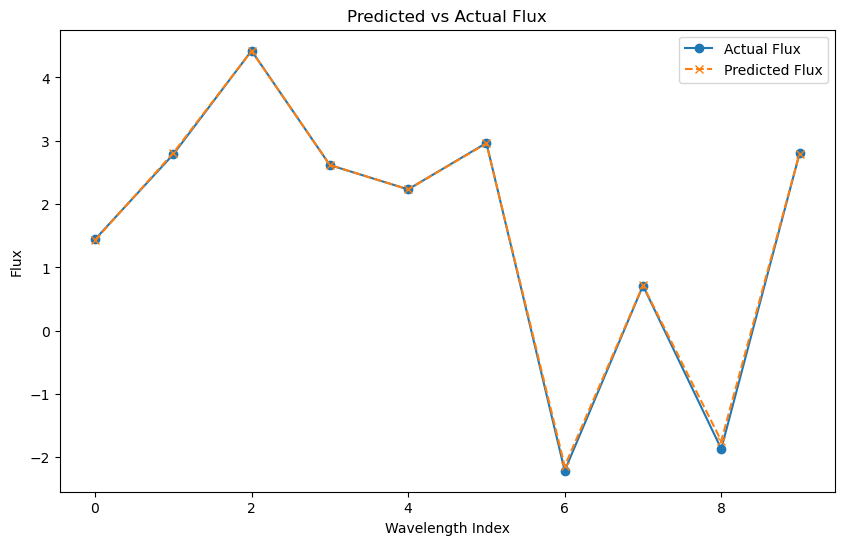

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
def plot_results(model, diffusion_model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_actuals = []

    with torch.no_grad():
        for x, y in dataloader:
            # Generate noisy input using the diffusion model
            y_noisy = diffusion_model.forward_process(y, noise_level=50)
            
            # Prepare x for input and concatenate
            x = x.unsqueeze(1).repeat(1, y.size(1))  # Adjust x dimensions
            input_data = torch.cat((y_noisy, x[:, :y_noisy.shape[1]]), dim=1)

            # Check and adjust input_data shape if needed
            if input_data.shape[1] != 20:
                # If it does not match the expected size, fix it by padding or slicing
                print(f"Adjusting input_data from {input_data.shape} to (batch_size, 20)")
                if input_data.shape[1] < 20:
                    # Pad with zeros if input is less than 20
                    padding = 20 - input_data.shape[1]
                    input_data = torch.nn.functional.pad(input_data, (0, padding))
                else:
                    # Slice if input exceeds 20
                    input_data = input_data[:, :20]

            # Get model predictions
            predicted_flux = model(input_data)
            
            # Store results as tensors
            all_preds.append(predicted_flux)
            all_actuals.append(y)

    # Convert lists to tensors and then to NumPy arrays for plotting
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_actuals = torch.cat(all_actuals).cpu().numpy()

    # Plot the actual vs predicted fluxes for one sample (example)
    plt.figure(figsize=(10, 6))
    plt.plot(all_actuals[0], label="Actual Flux", marker='o')
    plt.plot(all_preds[0], label="Predicted Flux", linestyle='--', marker='x')
    plt.title("Predicted vs Actual Flux")
    plt.xlabel("Wavelength Index")
    plt.ylabel("Flux")
    plt.legend()
    plt.show()

# Define the dataset class
class FluxDataset(Dataset):
    def __init__(self, data):
        self.wavelengths = data[:, 0]  # First column as wavelength
        self.fluxes = data[:, 1:]  # Remaining columns as fluxes

    def __len__(self):
        return len(self.wavelengths)

    def __getitem__(self, idx):
        return torch.tensor(self.wavelengths[idx], dtype=torch.float32), \
               torch.tensor(self.fluxes[idx], dtype=torch.float32)

class FluxPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FluxPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # Adjust input_dim as needed
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)


# Diffusion process class
class DiffusionModel:
    def __init__(self, model, timesteps=10000, beta_start=0.0001, beta_end=0.02):
        self.model = model
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1 - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
    
    def forward_process(self, y0, noise_level):
        alpha_t = self.alpha_cumprod[noise_level]
        noise = torch.randn_like(y0)
        return torch.sqrt(alpha_t) * y0 + torch.sqrt(1 - alpha_t) * noise

    def reverse_process(self, yt, x, noise_level):
        # Sample at time t
        alpha_t = self.alpha_cumprod[noise_level]
        alpha_t_1 = self.alpha_cumprod[noise_level - 1] if noise_level > 0 else alpha_t
        
        # Predict noise using the neural network
        predicted_noise = self.model(torch.cat((yt, x), dim=1))
        
        # Reconstruct y0
        y0_hat = (yt - torch.sqrt(1 - alpha_t) * predicted_noise) / torch.sqrt(alpha_t)
        
        # Reverse step
        yt_1 = torch.sqrt(alpha_t_1) * y0_hat + torch.sqrt(1 - alpha_t_1) * torch.randn_like(y0_hat)
        return yt_1

    def sample(self, x, num_samples=10):
        # Start from random noise
        yt = torch.randn((num_samples, x.size(1)))
        for t in reversed(range(self.timesteps)):
            yt = self.reverse_process(yt, x, t)
        return yt

def train(model, diffusion_model, dataloader, num_epochs=1000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            
            # Ensure x is properly reshaped
            x = x.unsqueeze(1).repeat(1, y.size(1))  # Ensure x has the same shape as y
            
            # Concatenate y_noisy and x properly
            y_noisy = diffusion_model.forward_process(y, noise_level=50)  # Example noise level
            input_data = torch.cat((y_noisy, x[:, :y_noisy.shape[1]]), dim=1)  # Adjust dimensions if needed

            # Verify the resulting input_data shape
            if input_data.shape[1] != 20:
                print(f"Unexpected input shape: {input_data.shape}")
                continue  # Skip this batch if shapes are incorrect

            # Forward pass and calculate loss
            predicted_noise = model(input_data)
            loss = criterion(predicted_noise, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}")

# Load and preprocess the data
data = pd.read_csv('../data/interpolated_spectra.csv').T  # Transpose as needed
data.reset_index(inplace=True)
data.columns = range(len(data.columns))
print(data)
# Ensure all columns are numeric
data = data.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric entries to NaN
data = data.dropna()  # Drop any rows that contain NaN values

# Check the shape of the data to confirm it aligns with your expectations
print("Data shape after processing:", data.shape)

# Convert to PyTorch tensor
data_tensor = torch.tensor(data.values, dtype=torch.float32)

# Create the dataset and dataloader
dataset = FluxDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# New input dimension after concatenation
input_dim = 20  # Updated from 11 to 20
output_dim = 10
flux_predictor = FluxPredictor(input_dim, output_dim)

diffusion = DiffusionModel(flux_predictor)

train(flux_predictor, diffusion, dataloader)
plot_results(flux_predictor, diffusion, dataloader)


c:\Users\vasil\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([17, 10])) that is different to the input size (torch.Size([17, 1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Loss = 1.890201210975647
Epoch 2: Loss = 1.7499154806137085
Epoch 3: Loss = 1.7417854070663452
Epoch 4: Loss = 0.9963797926902771
Epoch 5: Loss = 1.2949870824813843
Epoch 6: Loss = 1.156421184539795
Epoch 7: Loss = 1.8804956674575806
Epoch 8: Loss = 1.0628718137741089
Epoch 9: Loss = 1.3187423944473267
Epoch 10: Loss = 1.080157995223999
Epoch 11: Loss = 1.065596103668213
Epoch 12: Loss = 1.0325804948806763
Epoch 13: Loss = 1.071022391319275
Epoch 14: Loss = 0.9148927330970764
Epoch 15: Loss = 1.2838777303695679
Epoch 16: Loss = 1.2162514925003052
Epoch 17: Loss = 1.026310920715332
Epoch 18: Loss = 1.2542102336883545
Epoch 19: Loss = 1.182346224784851
Epoch 20: Loss = 0.9157076478004456
Epoch 21: Loss = 1.1777788400650024
Epoch 22: Loss = 0.9852730631828308
Epoch 23: Loss = 1.1000118255615234
Epoch 24: Loss = 1.0566169023513794
Epoch 25: Loss = 1.049802541732788
Epoch 26: Loss = 1.1710870265960693
Epoch 27: Loss = 1.1988142728805542
Epoch 28: Loss = 0.9489946365356445
Epoch 29:

IndexError: index 1 is out of bounds for dimension 1 with size 1

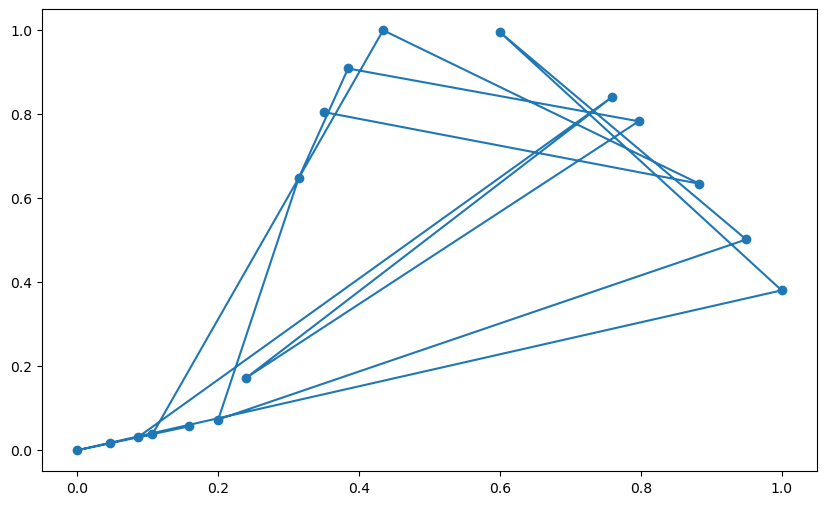

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Define the Dataset Class
class FluxDataset(Dataset):
    def __init__(self, csv_file):
        # Load the dataset
        data = pd.read_csv(csv_file).T
        data.reset_index(inplace=True)
        data.columns = range(len(data.columns))
        self.scaler = MinMaxScaler()
        self.wavelengths = data.iloc[:, 0].values.reshape(-1, 1)
        self.fluxes = data.iloc[:, 1:].values

        # Normalize
        self.wavelengths = self.scaler.fit_transform(self.wavelengths)
        self.fluxes = self.scaler.fit_transform(self.fluxes)

        # Convert to PyTorch tensors
        self.wavelengths = torch.tensor(self.wavelengths, dtype=torch.float32)
        self.fluxes = torch.tensor(self.fluxes, dtype=torch.float32)
    def __len__(self):
        return len(self.wavelengths)

    def __getitem__(self, idx):
        # Return a pair of (input, target)
        wavelength = self.wavelengths[idx]
        flux = self.fluxes[idx]
        return wavelength, flux

# Step 2: Define the TimeDiT Block
class TimeDiTBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TimeDiTBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# Step 3: Define the Diffusion Transformer Model
class TimeDiTDiffusionModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, max_timesteps):
        super(TimeDiTDiffusionModel, self).__init__()
        self.embedding = nn.Linear(1, embed_dim)  # Expecting 1 input feature for the wavelength
        self.time_embedding = nn.Embedding(max_timesteps, embed_dim)
        self.blocks = nn.ModuleList([
            TimeDiTBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ])
        self.output_projection = nn.Linear(embed_dim, input_dim)  # Output the flux predictions

    def forward(self, wavelength, t):
        # Embed the input wavelength and time step
        wavelength = wavelength.unsqueeze(-1)  # Ensure the input is [batch_size, 1]
        x = self.embedding(wavelength)
        
        # Ensure the time embedding is broadcastable to match `x`
        t_emb = self.time_embedding(t).unsqueeze(1)  # [batch_size, 1, embed_dim]
        x = x + t_emb

        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Project output to the original input dimension
        return self.output_projection(x)


# Step 4: Define the Diffusion Training Process
import matplotlib.pyplot as plt

class DiffusionTrainer:
    def __init__(self, model, noise_schedule, learning_rate=1e-4):
        self.model = model
        self.noise_schedule = noise_schedule
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

    def forward_diffusion(self, x0, noise_level):
        noise = torch.randn_like(x0)
        noisy_x = x0 * torch.sqrt(1 - noise_level) + noise * torch.sqrt(noise_level)
        return noisy_x, noise

    def train_step(self, wavelength, flux, t):
        # Simulate forward diffusion
        noise_level = self.noise_schedule[t]
        noisy_flux, noise = self.forward_diffusion(flux, noise_level)

        # Predict noise
        pred_noise = self.model(wavelength, torch.tensor([t], dtype=torch.long))

        # Compute loss
        loss = self.loss_fn(pred_noise, noise)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train(self, data_loader, epochs):
        for epoch in range(epochs):
            total_loss = 0
            for wavelength, flux in data_loader:
                t = torch.randint(0, len(self.noise_schedule), (1,)).item()
                loss = self.train_step(wavelength, flux, t)
                total_loss += loss
            print(f'Epoch {epoch + 1}: Loss = {total_loss / len(data_loader)}')

    # def generate_predictions(self, data_loader):
    #     self.model.eval()  # Switch model to evaluation mode
    #     with torch.no_grad():
    #         for wavelength, real_flux in data_loader:
    #             # Generate predictions using the trained model
    #             predicted_flux = self.model(wavelength, torch.tensor([0], dtype=torch.long))  # Using t=0 for evaluation
    #             self.plot_results(wavelength, real_flux, predicted_flux)
    #             break  # Only show for the first batch

    # def plot_results(self, wavelength, real_flux, predicted_flux):
    #     plt.figure(figsize=(10, 6))
    #     for i in range(real_flux.shape[1]):  # Assuming multiple flux columns
    #         plt.plot(wavelength, real_flux[:, i].numpy(), label=f'Real Flux {i+1}', linestyle='-', marker='o')
    #         plt.plot(wavelength, predicted_flux[:, i].numpy(), label=f'Predicted Flux {i+1}', linestyle='--', marker='x')

    #     plt.xlabel("Wavelength")
    #     plt.ylabel("Flux")
    #     plt.title("Real vs Predicted Fluxes")
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()
    def generate_predictions(self, data_loader):
        self.model.eval()  # Switch model to evaluation mode
        with torch.no_grad():
            for wavelength, real_flux in data_loader:
                # Generate predictions using the trained model
                predicted_flux = self.model(wavelength, torch.tensor([0], dtype=torch.long))
                
                # Remove batch dimension if it exists for easier plotting
                if predicted_flux.ndim == 3:
                    predicted_flux = predicted_flux.squeeze(0)  # Convert [1, 17, 10] -> [17, 10]
                if real_flux.ndim == 2:
                    real_flux = real_flux.squeeze(0)  # Convert [1, 17] -> [17]

                self.plot_results(wavelength, real_flux, predicted_flux)
                break  # Only show for the first batch

    def plot_results(self, wavelength, real_flux, predicted_flux):
        plt.figure(figsize=(10, 6))
        
        # Ensure wavelength is squeezed if it has extra dimensions
        if wavelength.ndim > 1:
            wavelength = wavelength.squeeze()

        for i in range(real_flux.shape[1]):  # Assuming multiple flux columns
            plt.plot(wavelength, real_flux[:, 1].numpy(), label=f'Real Flux {i+1}', linestyle='-', marker='o')
            plt.plot(wavelength, predicted_flux[:, 1].numpy(), label=f'Predicted Flux {i+1}', linestyle='--', marker='x')

        plt.xlabel("Wavelength")
        plt.ylabel("Flux")
        plt.title("Real vs Predicted Fluxes")
        plt.legend()
        plt.grid(True)
        plt.show()

# Step 5: Setup and Train the Model
if __name__ == "__main__":
    # Example usage
    csv_file = "../data/interpolated_spectra.csv"  # Replace this with the path to your dataset
    dataset = FluxDataset(csv_file)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Define the model parameters
    input_dim = 10  # 10 flux columns
    # Example: Increase dimensions
    embed_dim = 128  # From 64 to 128
    num_heads = 8    # From 4 to 8
    ff_dim = 256     # From 128 to 256

    num_layers = 6
    max_timesteps = 1000
    learning_rate = 1e-3  # Try smaller (1e-4) or higher values (5e-4)


    # Create the model
    model = TimeDiTDiffusionModel(input_dim, embed_dim, num_heads, ff_dim, num_layers, max_timesteps)

    # Define a noise schedule (linear for simplicity)
    noise_schedule = torch.linspace(0.0001, 0.02, max_timesteps)

    # Create the trainer
    trainer = DiffusionTrainer(model, noise_schedule, learning_rate)

    # Train the model
    # After training the model
    trainer.train(data_loader, epochs=1000)

    # Visualize the predictions
    trainer.generate_predictions(data_loader)
    # Visualize the predictions
    trainer.generate_predictions(data_loader)

